# Boosting Trees

In [18]:
import numpy as np
from collections import namedtuple
from sklearn.metrics import roc_curve, auc

# Load Basic Packages

In [2]:
import numpy as np
from collections import namedtuple

# Why build them from scratch?
+ Learning how the algorithm really works
+ Full control over every design choice – regularization, learning‑rate, leaf‑value calculation, etc.
+ No dependencies on black‑box libraries

# Gradient Boosting – Theory

---

## 1.  Additive Modelling

Gradient boosting constructs an **additive model**

$$
\hat{y}(x)=\sum_{k=1}^{K}\nu\,f_{k}(x),
$$

* \(f_{k}\) – the \(k^{\text{th}}\) weak learner (usually a decision tree).  
* \(\nu\in(0,1]\) – learning‑rate (shrinkage).  
* The goal is to minimise a differentiable loss function  
  \(L(y,F(x))\) where \(F(x)=\sum_{k} \nu f_k(x)\).

---

## 2.  Stage‑wise (Gradient) Boosting

At iteration \(m\):

1. **Compute negative gradients (pseudo‑residuals)**  

   $$ 
   r_{im}= -\left.\frac{\partial L(y_i,F(x_i))}{\partial F(x_i)}\right|_{F=F_{m-1}}, \qquad i=1,\dots,n .
   $$

2. **Fit a regression tree \(h_m(x)\) to \(\{(x_i,r_{im})\}\)** – the tree learns to predict the residual direction and magnitude.

3. **Update the ensemble**  

   $$
   F_m(x)=F_{m-1}(x)+\nu\,h_m(x).
   $$

The algorithm stops after a fixed number of trees or when the improvement falls below a threshold.

---


# Class for the tree Node

In [3]:
class TreeNode:
    def __init__(self, depth=0):
        self.left = None          # left child
        self.right = None         # right child
        self.feature_index = None
        self.threshold = None
        self.value = None         # leaf value
        self.depth = depth

# Find best split for a single feature

In [4]:
def _best_split_for_feature(X, residuals, feature_index, min_samples_leaf):
    """
    X        : 2D array (n_samples, n_features)
    residuals: 1D array (n_samples,)
    Returns (threshold, reduction_in_error) or (None, 0)
    """
    # sort samples by feature value
    sorted_idx = np.argsort(X[:, feature_index])
    X_sorted = X[sorted_idx, feature_index]
    r_sorted = residuals[sorted_idx]

    # Precompute cumulative sums for fast mean calculation
    cum_sum = np.cumsum(r_sorted)
    cum_sq = np.cumsum(r_sorted ** 2)

    N = len(r_sorted)
    best_reduction = -np.inf
    best_thresh = None

    # iterate over possible split points
    for i in range(min_samples_leaf, N - min_samples_leaf):
        # left side: samples 0..i
        N_left = i + 1
        sum_left = cum_sum[i]
        sq_left = cum_sq[i]
        mean_left = sum_left / N_left
        err_left = sq_left - 2 * mean_left * sum_left + N_left * mean_left ** 2

        # right side: samples i+1..N-1
        N_right = N - N_left
        sum_right = cum_sum[-1] - sum_left
        sq_right = cum_sq[-1] - sq_left
        mean_right = sum_right / N_right
        err_right = sq_right - 2 * mean_right * sum_right + N_right * mean_right ** 2

        # Total impurity after split
        err_total = err_left + err_right

        # Impurity decrease
        total_err = cum_sq[-1] - 2 * (cum_sum[-1] ** 2) / N + N * (cum_sum[-1] / N) ** 2
        reduction = total_err - err_total

        if reduction > best_reduction:
            best_reduction = reduction
            # split threshold is midpoint between two adjacent feature values
            best_thresh = (X_sorted[i] + X_sorted[i + 1]) / 2.0

    return best_thresh, best_reduction

# Build Tree function on the residuals

In [5]:
def _build_tree(X, residuals, depth=0, max_depth=3,
                min_samples_leaf=5, min_impurity_decrease=1e-7):
    node = TreeNode(depth=depth)

    # If we hit stopping criteria, make a leaf
    if depth >= max_depth or len(residuals) <= 2 * min_samples_leaf:
        node.value = np.mean(residuals)
        return node

    # Search for best split over all features
    best_feature = None
    best_thresh = None
    best_reduction = -np.inf

    for f in range(X.shape[1]):
        thresh, reduction = _best_split_for_feature(X, residuals, f, min_samples_leaf)
        if reduction > best_reduction:
            best_reduction = reduction
            best_feature = f
            best_thresh = thresh

    # If improvement is too small, make leaf
    if best_reduction < min_impurity_decrease or best_feature is None:
        node.value = np.mean(residuals)
        return node

    # Otherwise, split
    node.feature_index = best_feature
    node.threshold = best_thresh

    mask_left = X[:, best_feature] <= best_thresh
    X_left, X_right = X[mask_left], X[~mask_left]
    r_left, r_right = residuals[mask_left], residuals[~mask_left]

    node.left = _build_tree(X_left, r_left, depth + 1, max_depth,
                            min_samples_leaf, min_impurity_decrease)
    node.right = _build_tree(X_right, r_right, depth + 1, max_depth,
                             min_samples_leaf, min_impurity_decrease)
    return node

# Predict with a single tree

In [6]:
def _predict_tree(node, x):
    while node.value is None:  # internal node
        if x[node.feature_index] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value

# Boosting Tree Class

In [7]:
class GradientBoostingRegressorScratch:
    def __init__(self, n_estimators=100, learning_rate=0.1,
                 max_depth=3, min_samples_leaf=5,
                 min_impurity_decrease=1e-7, subsample=1.0,
                 random_state=None):
        self.n_estimators = n_estimators
        self.lr = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.subsample = subsample
        self.trees = []
        self.init_pred = None
        self.random_state = random_state

    # --------------------------------------------------------------
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        rng = np.random.RandomState(self.random_state)

        # Initial prediction: mean of y (optimal for MSE)
        self.init_pred = np.mean(y)
        F = np.full_like(y, self.init_pred, dtype=float)

        for m in range(self.n_estimators):
            # Negative gradient for MSE: residuals
            residuals = y - F

            # Subsample for stochastic gradient boosting
            if self.subsample < 1.0:
                idx = rng.choice(len(y), size=int(len(y) * self.subsample), replace=False)
                X_sub, res_sub = X[idx], residuals[idx]
            else:
                X_sub, res_sub = X, residuals

            # Fit a tree to residuals
            tree = _build_tree(X_sub, res_sub,
                               depth=0,
                               max_depth=self.max_depth,
                               min_samples_leaf=self.min_samples_leaf,
                               min_impurity_decrease=self.min_impurity_decrease)
            self.trees.append(tree)

            # Update model
            pred_tree = np.array([_predict_tree(tree, x) for x in X])
            F += self.lr * pred_tree

            # Optional: early stopping / diagnostics
            if (m + 1) % 10 == 0:
                loss = np.mean((y - F) ** 2)
                print(f"Iter {m+1}/{self.n_estimators} - MSE: {loss:.4f}")

    # --------------------------------------------------------------
    def predict(self, X):
        X = np.array(X)
        F = np.full(X.shape[0], self.init_pred, dtype=float)
        for tree in self.trees:
            F += self.lr * np.array([_predict_tree(tree, x) for x in X])
        return F

# Test it

In [16]:
if __name__ == "__main__":
    # ------------------------------
    # Load a toy regression dataset
    # ------------------------------
    from sklearn.datasets import fetch_openml
    from sklearn.preprocessing import LabelEncoder
    X, y = fetch_openml('iris', version=1, return_X_y=True, as_frame=False)
    le = LabelEncoder()
    y = le.fit_transform(y)            # y becomes array of 0,1,2


    # Train-test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # ------------------------------
    # Train our implementation
    # ------------------------------
    gbr = GradientBoostingRegressorScratch(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        min_samples_leaf=5,
        min_impurity_decrease=1e-7,
        subsample=0.8,
        random_state=0
    )
    gbr.fit(X_train, y_train)



Iter 10/200 - MSE: 0.2512
Iter 20/200 - MSE: 0.1052
Iter 30/200 - MSE: 0.0505
Iter 40/200 - MSE: 0.0302
Iter 50/200 - MSE: 0.0216
Iter 60/200 - MSE: 0.0175
Iter 70/200 - MSE: 0.0154
Iter 80/200 - MSE: 0.0141


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Iter 90/200 - MSE: 0.0132
Iter 100/200 - MSE: 0.0123
Iter 110/200 - MSE: 0.0115
Iter 120/200 - MSE: 0.0107
Iter 130/200 - MSE: 0.0104
Iter 140/200 - MSE: 0.0099
Iter 150/200 - MSE: 0.0092
Iter 160/200 - MSE: 0.0088
Iter 170/200 - MSE: 0.0085
Iter 180/200 - MSE: 0.0082
Iter 190/200 - MSE: 0.0078
Iter 200/200 - MSE: 0.0075
RMSE on test set: 0.073


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# -------------------------------------------------------------
# 1) Load data
# -------------------------------------------------------------
X, y = load_breast_cancer(return_X_y=True)      # 569 samples, 30 features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

Iter 10/300 - MSE: 0.0960
Iter 20/300 - MSE: 0.0431
Iter 30/300 - MSE: 0.0222
Iter 40/300 - MSE: 0.0130
Iter 50/300 - MSE: 0.0086
Iter 60/300 - MSE: 0.0062
Iter 70/300 - MSE: 0.0047
Iter 80/300 - MSE: 0.0038
Iter 90/300 - MSE: 0.0032
Iter 100/300 - MSE: 0.0027
Iter 110/300 - MSE: 0.0023
Iter 120/300 - MSE: 0.0020
Iter 130/300 - MSE: 0.0018
Iter 140/300 - MSE: 0.0016
Iter 150/300 - MSE: 0.0014
Iter 160/300 - MSE: 0.0012
Iter 170/300 - MSE: 0.0011
Iter 180/300 - MSE: 0.0010
Iter 190/300 - MSE: 0.0009
Iter 200/300 - MSE: 0.0008
Iter 210/300 - MSE: 0.0007
Iter 220/300 - MSE: 0.0006
Iter 230/300 - MSE: 0.0005
Iter 240/300 - MSE: 0.0005
Iter 250/300 - MSE: 0.0004
Iter 260/300 - MSE: 0.0004
Iter 270/300 - MSE: 0.0003
Iter 280/300 - MSE: 0.0003
Iter 290/300 - MSE: 0.0003
Iter 300/300 - MSE: 0.0002


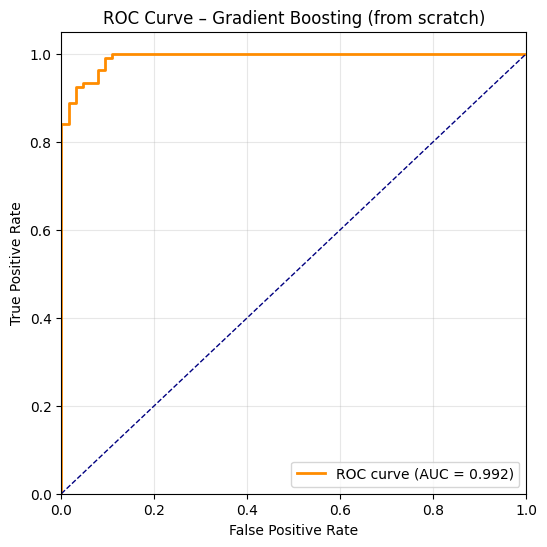

In [21]:
gbr = GradientBoostingRegressorScratch(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    min_samples_leaf=5,
    subsample=0.9,
    random_state=0
)
gbr.fit(X_train, y_train)

# -------------------------------------------------------------
# 4) Get scores (the raw output of the ensemble)
# -------------------------------------------------------------
scores = gbr.predict(X_test)   # higher → more likely class 1

# -------------------------------------------------------------
# 5) Compute ROC curve & AUC
# -------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# -------------------------------------------------------------
# 6) Plot
# -------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Gradient Boosting (from scratch)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()